<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/trivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
PLT_CELL = 2.5
figs_path = "/home/szhangubcmath/wtf/manuscript/figs/"

In [2]:
import os
import sys
os.chdir("/home/szhangubcmath/wtf")
sys.path.insert(0, "src")
import wtf

In [3]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

In [4]:
def gaussian(x, h):
    return np.exp(-(x/h)**2)

sizex = 128

x = np.linspace(-1, 1, sizex)
mu_x = [-0.25, -0.5, 0.5]
h_x = [0.25, 0.25, 0.25]
mu_y = [0, -0.5, 0.5]
h_y = [0.25, 0.25, 0.25]
mu_z = [0.5, -0.5, 0.5]
h_z = [0.1, 0.1, 0.25]

alpha = [wtf.normalise(gaussian(x - mu_x[i], h = h_x[i])) for i in range(len(mu_x))]
beta  = [wtf.normalise(gaussian(x - mu_y[i], h = h_y[i])) for i in range(len(mu_y))]
gamma = [wtf.normalise(gaussian(x - mu_z[i], h = h_z[i])) for i in range(len(mu_z))]

def outer_3(x, y, z):
    return np.einsum("i,j,k->ijk", x, y, z)

X = tl.tensor(sum([outer_3(alpha[i], beta[i], gamma[i]) for i in range(len(mu_x))]), dtype = tl_dtype)
X_orig = tl.copy(X)
X = X/X.max()

In [5]:
X = tl.tensor((np.random.random(size = X.shape) < 0.05*X.numpy())*1.0, dtype = tl_dtype)
# bit_mask = (np.random.random(size = X.shape) < 0.01)*1.0
# X = X*bit_mask.astype(np.float32)
X = X/X.sum()

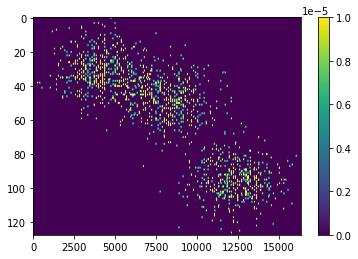

In [24]:
plt.imshow(tl.unfold(X, 0), vmax = 1e-5)
plt.axis("auto")
plt.colorbar()

In [7]:
C = ot.utils.euclidean_distances(x.reshape(-1, 1), x.reshape(-1, 1), squared = True)
C = torch.Tensor(C/C.mean()).to(device)

In [8]:
# now pick multilinear rank
d = 3
r = [3, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1/r[0]

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], n_iter_max = 0, init = "svd", random_state = 0)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0 = X.to(device) 

###

# good params
# n_iter = 10
# lr = np.ones(n_iter)*0.1
# lamda = np.array([np.ones(3), ]*n_iter)*10
# optim_modes = [0, ]
# rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
# eps = np.array([np.ones(3), ]*n_iter)*0.01
n_iter = 5
lamda = np.array([np.ones(3), ]*n_iter)*25
optim_modes = [0, ]
rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.0025
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [9]:
A = [a/a.sum(0) for a in A]

In [10]:
dual_objs = [[], [], [], ]

In [11]:
lr = np.ones(n_iter)*3e-4
max_iter, print_inter, check_iter, tol, unbal = (1000, 100, 100, 1e-2, True)
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0, 0, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "full", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[0] += [wtf.solve(m0, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0, 1, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "full", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[1] += [wtf.solve(m1, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0, 2, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "full", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[2] += [wtf.solve(m2, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = wtf.CoreModel(X0, [C, ]*3, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "full", device = device, unbal = unbal, norm = "full")
    # wtf.solve(m, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 0.184670
i = 100 	 dual = 0.145750
i = 200 	 dual = 0.116917
i = 300 	 dual = 0.091144
i = 400 	 dual = 0.066933
i = 500 	 dual = 0.043778
i = 600 	 dual = 0.021427
i = 700 	 dual = -0.000256
i = 800 	 dual = -0.021337
i = 900 	 dual = -0.041843
Mode 1
i = 0 	 dual = 0.184709
i = 100 	 dual = 0.154114
i = 200 	 dual = 0.133527
i = 300 	 dual = 0.114829
i = 400 	 dual = 0.096982
i = 500 	 dual = 0.079641
i = 600 	 dual = 0.062612
i = 700 	 dual = 0.045791
i = 800 	 dual = 0.029111
i = 900 	 dual = 0.012518
Mode 2
i = 0 	 dual = 0.184735
i = 100 	 dual = 0.160516
i = 200 	 dual = 0.144766
i = 300 	 dual = 0.130448
i = 400 	 dual = 0.117089
i = 500 	 dual = 0.104606
i = 600 	 dual = 0.092966
i = 700 	 dual = 0.082144
i = 800 	 dual = 0.072112
Block iteration  1
Mode 0
i = 0 	 dual = 0.184770
i = 100 	 dual = 0.160798
i = 200 	 dual = 0.145075
i = 300 	 dual = 0.131511
i = 400 	 dual = 0.119371
i = 500 	 dual = 0.108327
i = 600 	 dual = 0.098169
Mod

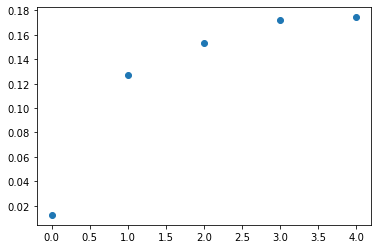

In [12]:
plt.scatter(np.arange(n_iter), dual_objs[1])

(-0.5, 8.5, 2.5, -0.5)

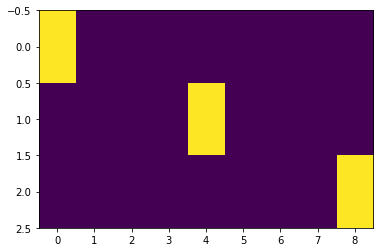

In [13]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

In [14]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], init = "svd", n_iter_max = 500)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

(-0.5, 127.5, 16383.5, -0.5)

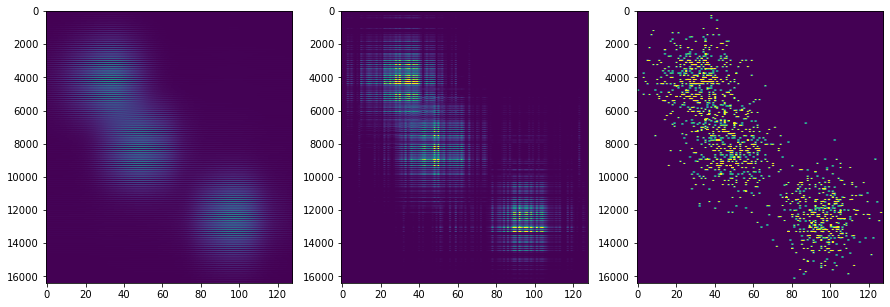

In [18]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat.reshape(-1, sizex**2).T, vmax = 1e-5)
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp.reshape(-1, sizex**2).T, vmax = 1e-5)
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X.reshape(-1, sizex**2).T, vmax = 1e-5)
plt.axis("auto")

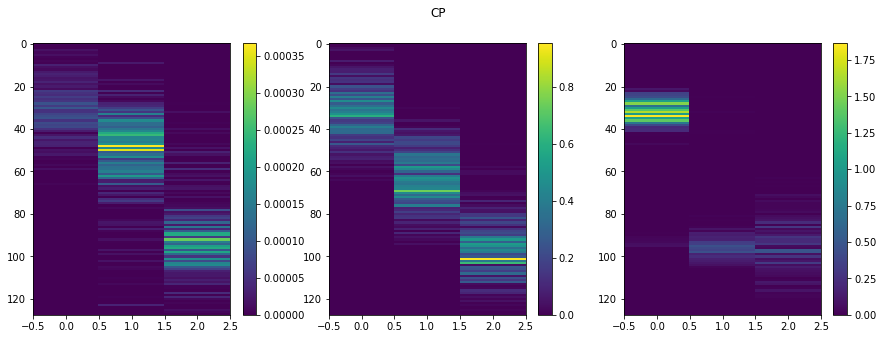

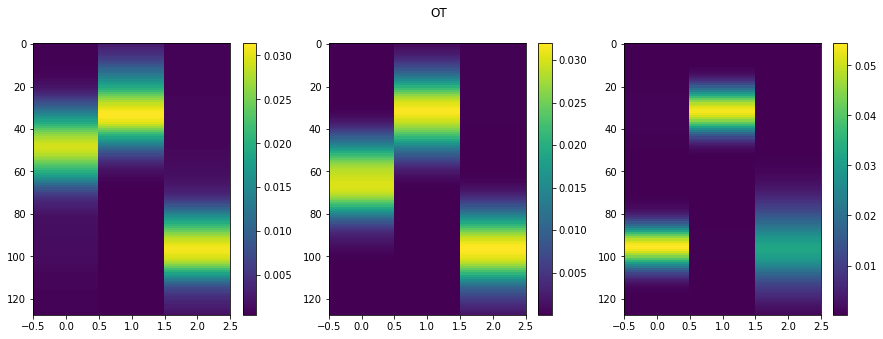

In [19]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

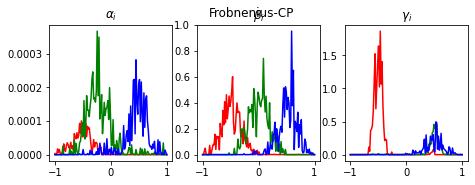

In [20]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("Frobnenius-CP")
plt.subplot(1, 3, 1)
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[0][:, 0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[0][:, 1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[0][:, 2], color = "blue")
plt.subplot(1, 3, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[1][:, 0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[1][:, 1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[1][:, 2], color = "blue")
plt.subplot(1, 3, 3)
plt.title("$\\gamma_i$")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[2][:, 0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[2][:, 1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), factor_cp.factors[2][:, 2], color = "blue")
plt.savefig(figs_path + "3mode_atoms_cp.pdf")

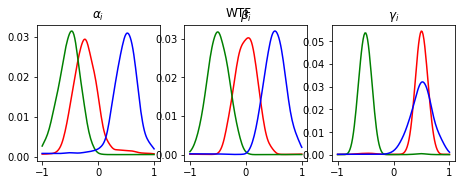

In [21]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("WTF")
plt.subplot(1, 3, 1)
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, sizex), A[0][:, 0].cpu(), color = "red")
plt.plot(np.linspace(-1, 1, sizex), A[0][:, 1].cpu(), color = "green")
plt.plot(np.linspace(-1, 1, sizex), A[0][:, 2].cpu(), color = "blue")
plt.subplot(1, 3, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, sizex), A[1][:, 0].cpu(), color = "red")
plt.plot(np.linspace(-1, 1, sizex), A[1][:, 1].cpu(), color = "green")
plt.plot(np.linspace(-1, 1, sizex), A[1][:, 2].cpu(), color = "blue")
plt.subplot(1, 3, 3)
plt.title("$\\gamma_i$")
plt.plot(np.linspace(-1, 1, sizex), A[2][:, 0].cpu(), color = "red")
plt.plot(np.linspace(-1, 1, sizex), A[2][:, 1].cpu(), color = "green")
plt.plot(np.linspace(-1, 1, sizex), A[2][:, 2].cpu(), color = "blue")
plt.savefig(figs_path + "3mode_atoms_wtf.pdf")

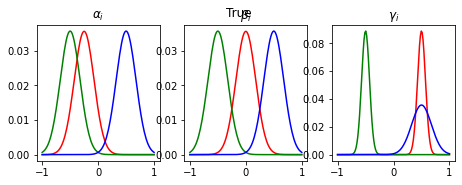

In [22]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("True")
plt.subplot(1, 3, 1)
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, sizex), alpha[0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), alpha[1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), alpha[2], color = "blue")
plt.subplot(1, 3, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, sizex), beta[0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), beta[1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), beta[2], color = "blue")
plt.subplot(1, 3, 3)
plt.title("$\\gamma_i$")
plt.plot(np.linspace(-1, 1, sizex), gamma[0], color = "red")
plt.plot(np.linspace(-1, 1, sizex), gamma[1], color = "green")
plt.plot(np.linspace(-1, 1, sizex), gamma[2], color = "blue")
plt.savefig(figs_path + "3mode_atoms_wtf.pdf")

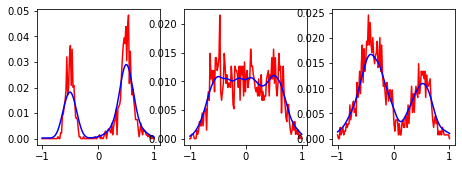

In [23]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
plt.plot(np.linspace(-1, 1, sizex), X.sum(0).sum(0), color = "red");
plt.plot(np.linspace(-1, 1, sizex), X_hat.sum(0).sum(0), color = "blue");
plt.subplot(1, 3, 2)
plt.plot(np.linspace(-1, 1, sizex), X.sum(0).sum(1), color = "red");
plt.plot(np.linspace(-1, 1, sizex), X_hat.sum(0).sum(1), color = "blue");
plt.subplot(1, 3, 3)
plt.plot(np.linspace(-1, 1, sizex), X.sum(1).sum(1), color = "red");
plt.plot(np.linspace(-1, 1, sizex), X_hat.sum(1).sum(1), color = "blue");